In [1]:
import os, glob, random
from collections import Counter

import numpy as np
import pandas as pd

from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
INPUT_DIR = "/kaggle/input/crop-and-weed-detection-data-with-bounding-boxes"
img_exts = (".jpg",".jpeg",".png")

all_imgs, all_xmls, all_txts = [], [], []
for root, _, files in os.walk(INPUT_DIR):
    for f in files:
        fp = os.path.join(root, f)
        if f.lower().endswith(img_exts):
            all_imgs.append(fp)
        elif f.lower().endswith(".xml"):
            all_xmls.append(fp)
        elif f.lower().endswith(".txt"):
            all_txts.append(fp)

print("Images:", len(all_imgs))
print("XMLs  :", len(all_xmls))
print("TXTs  :", len(all_txts))
print("Example image:", all_imgs[0] if all_imgs else None)
print("Example xml  :", all_xmls[0] if all_xmls else None)
print("Example txt  :", all_txts[0] if all_txts else None)

Images: 1300
XMLs  : 0
TXTs  : 1301
Example image: /kaggle/input/crop-and-weed-detection-data-with-bounding-boxes/agri_data/data/agri_0_7209.jpeg
Example xml  : None
Example txt  : /kaggle/input/crop-and-weed-detection-data-with-bounding-boxes/classes.txt


In [3]:
def find_image_by_stem(stem):
    hits = []
    for ext in img_exts:
        hits += glob.glob(os.path.join(INPUT_DIR, "**", stem + ext), recursive=True)
    return hits[0] if hits else None

df = None

# --- Try VOC XML first ---
if len(all_xmls) > 0:
    import xml.etree.ElementTree as ET
    
    def find_image_by_filename(fn):
        hits = glob.glob(os.path.join(INPUT_DIR, "**", fn), recursive=True)
        return hits[0] if hits else None

    def parse_voc_xml(xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()

        filename = root.findtext("filename")
        size = root.find("size")
        width = int(size.findtext("width"))
        height = int(size.findtext("height"))

        rows = []
        for obj in root.findall("object"):
            label = obj.findtext("name").strip()
            bnd = obj.find("bndbox")
            xmin = int(float(bnd.findtext("xmin")))
            ymin = int(float(bnd.findtext("ymin")))
            xmax = int(float(bnd.findtext("xmax")))
            ymax = int(float(bnd.findtext("ymax")))

            rows.append({
                "ann_format": "voc_xml",
                "ann_path": xml_path,
                "filename": filename,
                "img_path": find_image_by_filename(filename),
                "width": width, "height": height,
                "label": label,
                "xmin": xmin, "ymin": ymin, "xmax": xmax, "ymax": ymax
            })
        return rows

    rows = []
    for x in all_xmls:
        try:
            rows.extend(parse_voc_xml(x))
        except:
            pass

    df = pd.DataFrame(rows)
    print("Built df from XML. Rows:", len(df))

# --- Else, try YOLO txt ---
if (df is None or len(df) == 0) and len(all_txts) > 0:
    def is_yolo_file(txt_path):
        try:
            with open(txt_path, "r") as f:
                lines = [l.strip() for l in f.readlines() if l.strip()]
            if len(lines) == 0:
                return False
            return len(lines[0].split()) == 5
        except:
            return False

    yolo_txts = [t for t in all_txts if is_yolo_file(t)]
    print("YOLO-like txt files:", len(yolo_txts))

    def parse_yolo_txt(txt_path):
        stem = os.path.splitext(os.path.basename(txt_path))[0]
        img_path = find_image_by_stem(stem)
        if img_path is None:
            return []

        img = Image.open(img_path)
        W, H = img.size

        rows = []
        with open(txt_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                cid, xc, yc, w, h = parts
                cid = int(float(cid))
                xc, yc, w, h = map(float, [xc, yc, w, h])

                xmin = int((xc - w/2) * W)
                ymin = int((yc - h/2) * H)
                xmax = int((xc + w/2) * W)
                ymax = int((yc + h/2) * H)

                rows.append({
                    "ann_format": "yolo_txt",
                    "ann_path": txt_path,
                    "img_path": img_path,
                    "width": W, "height": H,
                    "label": str(cid),
                    "xmin": xmin, "ymin": ymin, "xmax": xmax, "ymax": ymax
                })
        return rows

    rows = []
    for t in yolo_txts:
        try:
            rows.extend(parse_yolo_txt(t))
        except:
            pass

    df = pd.DataFrame(rows)
    print("Built df from YOLO TXT. Rows:", len(df))

if df is None or len(df) == 0:
    raise ValueError("No usable XML/YOLO annotations found.")

df = df.dropna(subset=["img_path"]).reset_index(drop=True)
print("Final df rows:", len(df))
print("Columns:", df.columns.tolist())
df.head()

YOLO-like txt files: 1300
Built df from YOLO TXT. Rows: 2072
Final df rows: 2072
Columns: ['ann_format', 'ann_path', 'img_path', 'width', 'height', 'label', 'xmin', 'ymin', 'xmax', 'ymax']


,ann_format,ann_path,img_path,width,height,label,xmin,ymin,xmax,ymax
0,yolo_txt,/kaggle/input/crop-and-weed-detection-data-wit...,/kaggle/input/crop-and-weed-detection-data-wit...,512,512,0,16,200,497,423
1,yolo_txt,/kaggle/input/crop-and-weed-detection-data-wit...,/kaggle/input/crop-and-weed-detection-data-wit...,512,512,1,157,148,464,437
2,yolo_txt,/kaggle/input/crop-and-weed-detection-data-wit...,/kaggle/input/crop-and-weed-detection-data-wit...,512,512,0,48,0,512,502
3,yolo_txt,/kaggle/input/crop-and-weed-detection-data-wit...,/kaggle/input/crop-and-weed-detection-data-wit...,512,512,1,88,107,444,394
4,yolo_txt,/kaggle/input/crop-and-weed-detection-data-wit...,/kaggle/input/crop-and-weed-detection-data-wit...,512,512,1,108,123,392,312


Total boxes: 2072
Unique label files: 1300
Unique images: 1300
Unique labels: 2
Labels: ['0' '1']


0    1212
1     860
Name: label, dtype: int64

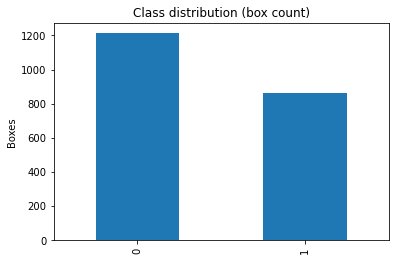

In [4]:
print("Total boxes:", len(df))
print("Unique label files:", df["ann_path"].nunique())
print("Unique images:", df["img_path"].nunique())
print("Unique labels:", df["label"].nunique())
print("Labels:", df["label"].unique())

label_counts = df["label"].value_counts()
display(label_counts)

plt.figure()
label_counts.plot(kind="bar")
plt.title("Class distribution (box count)")
plt.ylabel("Boxes")
plt.show()

count    1300.000000
mean        1.593846
std         1.950020
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        19.000000
dtype: float64

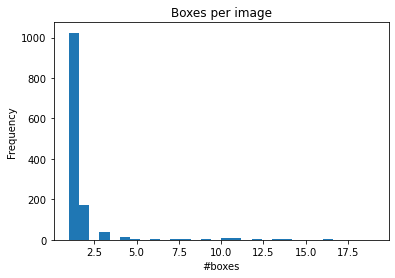

In [5]:
boxes_per_image = df.groupby("img_path").size()
display(boxes_per_image.describe())

plt.figure()
boxes_per_image.plot(kind="hist", bins=30)
plt.title("Boxes per image")
plt.xlabel("#boxes")
plt.show()

,box_w,box_h,box_area,box_ar
count,2072.000000,2072.000000,2072.000000,2072.000000
mean,260.792954,236.121139,81835.592664,1.146364
std,159.522680,144.499143,72915.345437,0.390094
min,21.000000,19.000000,483.000000,0.231441
25%,93.000000,97.000000,7867.500000,0.912384
50%,284.000000,241.000000,70362.500000,1.079989
75%,401.000000,346.000000,138271.000000,1.339855
max,511.000000,511.000000,259077.000000,3.973451


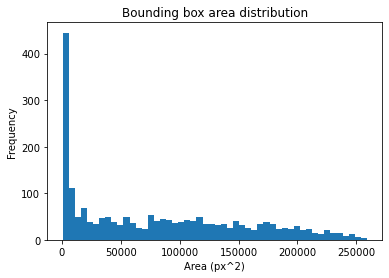

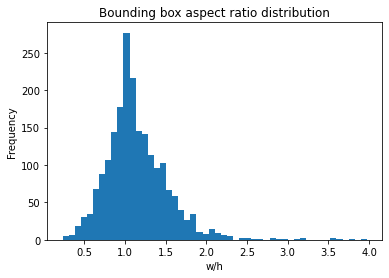

In [6]:
df["box_w"] = (df["xmax"] - df["xmin"]).clip(lower=1)
df["box_h"] = (df["ymax"] - df["ymin"]).clip(lower=1)
df["box_area"] = df["box_w"] * df["box_h"]
df["box_ar"] = df["box_w"] / df["box_h"]

display(df[["box_w","box_h","box_area","box_ar"]].describe())

plt.figure()
df["box_area"].plot(kind="hist", bins=50)
plt.title("Bounding box area distribution")
plt.xlabel("Area (px^2)")
plt.show()

plt.figure()
df["box_ar"].plot(kind="hist", bins=50)
plt.title("Bounding box aspect ratio distribution")
plt.xlabel("w/h")
plt.show()

In [7]:
invalid = df[(df.xmin >= df.xmax) | (df.ymin >= df.ymax)]
print("Invalid boxes:", len(invalid))

oob = df[(df.xmin < 0) | (df.ymin < 0) | (df.xmax > df.width) | (df.ymax > df.height)]
print("Out-of-bounds boxes:", len(oob))

Invalid boxes: 0
Out-of-bounds boxes: 0


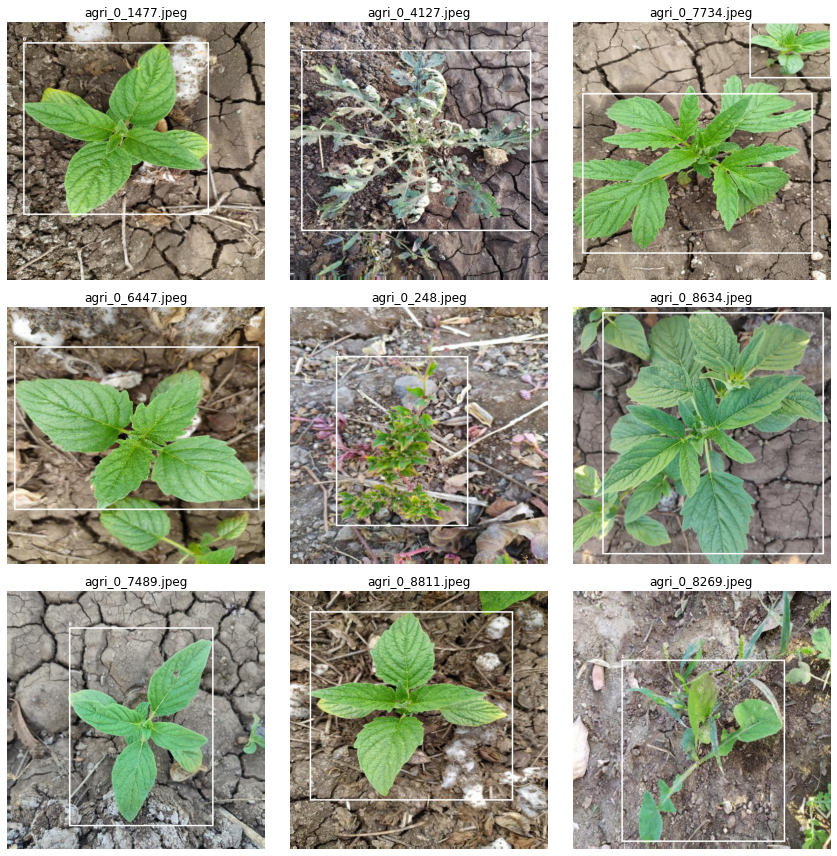

In [8]:
import PIL.ImageDraw as ImageDraw

def draw_boxes(img, subdf):
    img = img.copy()
    d = ImageDraw.Draw(img)
    for _, r in subdf.iterrows():
        d.rectangle([r.xmin, r.ymin, r.xmax, r.ymax], width=3)
        d.text((r.xmin, max(0, r.ymin-12)), str(r.label))
    return img

sample_imgs = random.sample(list(df["img_path"].unique()), k=min(9, df["img_path"].nunique()))
plt.figure(figsize=(12,12))
for i, p in enumerate(sample_imgs, 1):
    img = Image.open(p).convert("RGB")
    sub = df[df["img_path"] == p]
    plt.subplot(3,3,i)
    plt.imshow(draw_boxes(img, sub))
    plt.axis("off")
    plt.title(os.path.basename(p))
plt.tight_layout()
plt.show()

In [9]:
sample_paths = random.sample(all_imgs, k=min(300, len(all_imgs)))
means, stds = [], []

for p in sample_paths:
    im = Image.open(p).convert("RGB")
    arr = np.asarray(im).astype(np.float32) / 255.0
    means.append(arr.mean(axis=(0,1)))
    stds.append(arr.std(axis=(0,1)))

mean_rgb = np.mean(means, axis=0)
std_rgb  = np.mean(stds, axis=0)

print("Mean RGB:", mean_rgb)
print("Std  RGB:", std_rgb)


Mean RGB: [0.5196759  0.5336864  0.46098033]
Std  RGB: [0.1538357  0.1712148  0.15309182]


In [10]:
df["label_id"] = df["label"].astype(int)
num_classes = df["label_id"].nunique()
print("num_classes:", num_classes)

num_classes: 2


In [11]:
unique_imgs = df["img_path"].unique().tolist()
random.shuffle(unique_imgs)

split = int(0.8 * len(unique_imgs))
train_imgs = set(unique_imgs[:split])
val_imgs   = set(unique_imgs[split:])

train_df = df[df["img_path"].isin(train_imgs)].reset_index(drop=True)
val_df   = df[df["img_path"].isin(val_imgs)].reset_index(drop=True)

print("Train boxes:", len(train_df), "| Val boxes:", len(val_df))
print("Train images:", len(train_imgs), "| Val images:", len(val_imgs))

Train boxes: 1624 | Val boxes: 448
Train images: 1040 | Val images: 260


In [12]:
class CropDataset(Dataset):
    def __init__(self, ann_df, out_size=224, augment=False, mean=None, std=None):
        self.df = ann_df
        self.out_size = out_size
        self.augment = augment

        self.mean = torch.tensor(mean, dtype=torch.float32).view(3,1,1) if mean is not None else None
        self.std  = torch.tensor(std, dtype=torch.float32).view(3,1,1) if std is not None else None

    def __len__(self):
        return len(self.df)

    def _to_tensor(self, img):
        arr = np.asarray(img).astype(np.float32) / 255.0
        arr = np.transpose(arr, (2,0,1))
        x = torch.tensor(arr, dtype=torch.float32)
        if self.mean is not None and self.std is not None:
            x = (x - self.mean) / (self.std + 1e-6)
        return x

    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        img = Image.open(r.img_path).convert("RGB")

        # clip bbox to image bounds
        xmin = max(0, int(r.xmin)); ymin = max(0, int(r.ymin))
        xmax = min(int(r.width), int(r.xmax)); ymax = min(int(r.height), int(r.ymax))
        if xmax <= xmin: xmax = xmin + 1
        if ymax <= ymin: ymax = ymin + 1

        crop = img.crop((xmin, ymin, xmax, ymax)).resize((self.out_size, self.out_size))

        # simple augmentations
        if self.augment:
            if random.random() < 0.5:
                crop = crop.transpose(Image.FLIP_LEFT_RIGHT)
            if random.random() < 0.1:
                crop = crop.transpose(Image.FLIP_TOP_BOTTOM)

        x = self._to_tensor(crop)
        y = int(r.label_id)
        return x, y

mean_list = mean_rgb.tolist()
std_list  = std_rgb.tolist()

train_ds = CropDataset(train_df, out_size=224, augment=True, mean=mean_list, std=std_list)
val_ds   = CropDataset(val_df, out_size=224, augment=False, mean=mean_list, std=std_list)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

In [13]:
class MLP(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout),
        )
    def forward(self, x):
        return self.net(x)

class TransformerEncoderBlock(nn.Module):
    def __init__(self, dim, heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, int(dim*mlp_ratio), dropout=dropout)

    def forward(self, x):
        x_norm = self.norm1(x)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm, need_weights=False)
        x = x + attn_out
        x = x + self.mlp(self.norm2(x))
        return x

class ViT(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=2,
                 dim=256, depth=6, heads=8, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        assert img_size % patch_size == 0

        self.num_patches = (img_size // patch_size) ** 2
        self.patch_embed = nn.Conv2d(in_chans, dim, kernel_size=patch_size, stride=patch_size)

        self.cls_token = nn.Parameter(torch.zeros(1, 1, dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.num_patches, dim))
        self.pos_drop = nn.Dropout(dropout)

        self.blocks = nn.ModuleList([
            TransformerEncoderBlock(dim, heads, mlp_ratio=mlp_ratio, dropout=dropout)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, num_classes)

        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.head.weight, std=0.02)
        nn.init.zeros_(self.head.bias)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)                 # (B, D, H/ps, W/ps)
        x = x.flatten(2).transpose(1, 2)        # (B, N, D)

        cls = self.cls_token.expand(B, -1, -1)  # (B,1,D)
        x = torch.cat([cls, x], dim=1)          # (B,1+N,D)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        return self.head(x[:, 0])               # CLS token

In [14]:
import torch
import torch.nn as nn


class MLP(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


class TransformerEncoderBlock(nn.Module):
    def __init__(self, dim, heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(
            embed_dim=dim,
            num_heads=heads,
            dropout=dropout
        )
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, int(dim * mlp_ratio), dropout=dropout)

    def forward(self, x):
        # x: (B, N, D)
        x_norm = self.norm1(x)

        # MultiheadAttention expects (N, B, D)
        x_attn = x_norm.transpose(0, 1)
        attn_out, _ = self.attn(x_attn, x_attn, x_attn)
        attn_out = attn_out.transpose(0, 1)

        x = x + attn_out
        x = x + self.mlp(self.norm2(x))
        return x


def trunc_normal_(tensor, mean=0.0, std=1.0, a=-2.0, b=2.0):
    with torch.no_grad():
        size = tensor.shape
        tmp = tensor.new_empty(size + (4,)).normal_()
        valid = (tmp > a) & (tmp < b)
        ind = valid.max(-1, keepdim=True)[1]
        tensor.copy_(tmp.gather(-1, ind).squeeze(-1))
        tensor.mul_(std).add_(mean)
        return tensor


class ViT(nn.Module):
    def __init__(
        self,
        img_size=224,
        patch_size=16,
        in_chans=3,
        num_classes=2,
        dim=256,
        depth=6,
        heads=8,
        mlp_ratio=4.0,
        dropout=0.1,
    ):
        super().__init__()
        assert img_size % patch_size == 0

        self.num_patches = (img_size // patch_size) ** 2

        # Patch embedding
        self.patch_embed = nn.Conv2d(
            in_chans,
            dim,
            kernel_size=patch_size,
            stride=patch_size,
        )

        # Tokens
        self.cls_token = nn.Parameter(torch.zeros(1, 1, dim))
        self.pos_embed = nn.Parameter(
            torch.zeros(1, 1 + self.num_patches, dim)
        )
        self.pos_drop = nn.Dropout(dropout)

        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerEncoderBlock(dim, heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, num_classes)

        # Initialization
        trunc_normal_(self.pos_embed, std=0.02)
        trunc_normal_(self.cls_token, std=0.02)
        trunc_normal_(self.head.weight, std=0.02)
        nn.init.zeros_(self.head.bias)

    def forward(self, x):
        B = x.size(0)

        x = self.patch_embed(x)                  # (B, D, H/ps, W/ps)
        x = x.flatten(2).transpose(1, 2)         # (B, N, D)

        cls = self.cls_token.expand(B, -1, -1)   # (B, 1, D)
        x = torch.cat([cls, x], dim=1)           # (B, 1+N, D)

        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        return self.head(x[:, 0])                # CLS token

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViT(
    img_size=224,
    patch_size=16,
    num_classes=2,
    dim=256,
    depth=6,
    heads=8,
    dropout=0.1
).to(device)

In [16]:
# Class weights (helps because your classes are imbalanced: 0=1212, 1=860 approx)
counts = train_df["label_id"].value_counts().sort_index()
w0 = 1.0 / counts.iloc[0]
w1 = 1.0 / counts.iloc[1]
class_weights = torch.tensor([w0, w1], dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.05)

print("Class counts:", counts.to_dict())
print("Class weights:", class_weights.detach().cpu().numpy())

Class counts: {0: 924, 1: 700}
Class weights: [0.00108225 0.00142857]


In [17]:
def accuracy_from_logits(logits, y):
    preds = torch.argmax(logits, dim=1)
    return (preds == y).float().mean().item()

def run_epoch(loader, train=True):
    model.train() if train else model.eval()

    total_loss = 0.0
    total_acc = 0.0
    n = 0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        if train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            logits = model(x)
            loss = criterion(logits, y)

            if train:
                loss.backward()
                optimizer.step()

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_from_logits(logits, y) * bs
        n += bs

    return total_loss / n, total_acc / n

In [18]:
epochs = 15
history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}

for e in range(1, epochs+1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader, train=False)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)

    print(f"Epoch {e:02d} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")


Epoch 01 | train loss 0.4297 acc 0.8060 | val loss 0.3955 acc 0.8393
Epoch 02 | train loss 0.2738 acc 0.8947 | val loss 0.3186 acc 0.8728
Epoch 03 | train loss 0.2119 acc 0.9280 | val loss 0.1876 acc 0.9353
Epoch 04 | train loss 0.1826 acc 0.9421 | val loss 0.2486 acc 0.9107
Epoch 05 | train loss 0.2028 acc 0.9249 | val loss 0.1827 acc 0.9308
Epoch 06 | train loss 0.1358 acc 0.9618 | val loss 0.2111 acc 0.9286
Epoch 07 | train loss 0.1370 acc 0.9581 | val loss 0.1922 acc 0.9397
Epoch 08 | train loss 0.1390 acc 0.9532 | val loss 0.1890 acc 0.9420
Epoch 09 | train loss 0.1327 acc 0.9581 | val loss 0.1816 acc 0.9196
Epoch 10 | train loss 0.1209 acc 0.9649 | val loss 0.1596 acc 0.9509
Epoch 11 | train loss 0.1390 acc 0.9575 | val loss 0.1748 acc 0.9531
Epoch 12 | train loss 0.1050 acc 0.9711 | val loss 0.1718 acc 0.9487
Epoch 13 | train loss 0.1277 acc 0.9569 | val loss 0.1335 acc 0.9576
Epoch 14 | train loss 0.1100 acc 0.9674 | val loss 0.1324 acc 0.9665
Epoch 15 | train loss 0.1087 acc 0

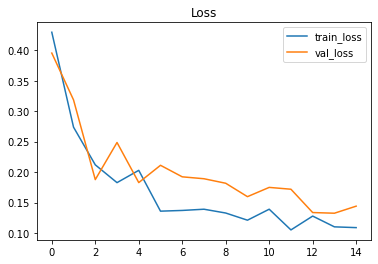

In [19]:
plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.figure()
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.legend()
plt.title("Accuracy")
plt.show()

Confusion Matrix (rows=true, cols=pred):
[[281   7]
 [ 12 148]]


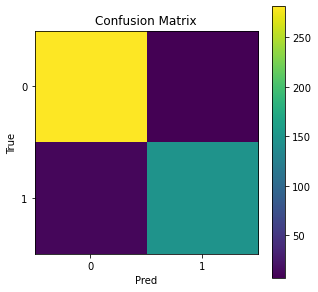

In [21]:
def get_preds(loader):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            pred = torch.argmax(logits, dim=1).cpu().numpy()
            ps.extend(pred.tolist())
            ys.extend(y.numpy().tolist())
    return np.array(ys), np.array(ps)

y_true, y_pred = get_preds(val_loader)

cm = np.zeros((2,2), dtype=int)
for t,p in zip(y_true, y_pred):
    cm[t,p] += 1

print("Confusion Matrix (rows=true, cols=pred):")
print(cm)

plt.figure(figsize=(5,5))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Pred")
plt.ylabel("True")
plt.colorbar()
plt.xticks([0,1], ["0","1"])
plt.yticks([0,1], ["0","1"])
plt.show()

In [22]:
torch.save({
    "model_state": model.state_dict(),
    "label_map": {"0":0, "1":1},
    "mean_rgb": mean_list,
    "std_rgb": std_list
}, "vit_from_scratch_cropweed.pth")

print("Saved: vit_from_scratch_cropweed.pth")

Saved: vit_from_scratch_cropweed.pth


In [23]:
import torch
import numpy as np
from PIL import Image

# --------- load checkpoint ----------
CKPT_PATH = "vit_from_scratch_cropweed.pth"  # adjust if different

ckpt = torch.load(CKPT_PATH, map_location="cpu")

# mean/std from training (saved in ckpt)
mean_list = ckpt["mean_rgb"]
std_list  = ckpt["std_rgb"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------- rebuild your ViT (same class as training) ----------
# Ensure these are already defined in your notebook:
# trunc_normal_, MLP, TransformerEncoderBlock, ViT

model = ViT(img_size=224, patch_size=16, num_classes=2, dim=256, depth=6, heads=8, dropout=0.1).to(device)
model.load_state_dict(ckpt["model_state"], strict=True)
model.eval()

id2name = {0: "Class 0", 1: "Class 1"}  # rename later if you know which is crop/weed

mean_t = torch.tensor(mean_list, dtype=torch.float32).view(3,1,1)
std_t  = torch.tensor(std_list, dtype=torch.float32).view(3,1,1)

def preprocess_pil(pil_img):
    pil_img = pil_img.convert("RGB").resize((224,224))
    arr = np.asarray(pil_img).astype(np.float32) / 255.0
    arr = np.transpose(arr, (2,0,1))  # CHW
    x = torch.tensor(arr, dtype=torch.float32)
    x = (x - mean_t) / (std_t + 1e-6)
    return x.unsqueeze(0)  # (1,3,224,224)

@torch.no_grad()
def predict_pil(pil_img):
    x = preprocess_pil(pil_img).to(device)
    logits = model(x)
    probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
    pred_id = int(np.argmax(probs))
    return pred_id, probs

In [36]:
query_path = "/kaggle/input/crop-and-weed-detection-data-with-bounding-boxes/agri_data/data/agri_0_1173.jpeg"  # change this
img = Image.open(query_path)

pred_id, probs = predict_pil(img)
print("Prediction:", id2name[pred_id])
print("Probabilities:", probs)


Prediction: Class 1
Probabilities: [0.01289422 0.98710585]


In [37]:
def crop_with_box(pil_img, xmin, ymin, xmax, ymax):
    W, H = pil_img.size
    xmin = max(0, min(int(xmin), W-1))
    ymin = max(0, min(int(ymin), H-1))
    xmax = max(xmin+1, min(int(xmax), W))
    ymax = max(ymin+1, min(int(ymax), H))
    return pil_img.crop((xmin, ymin, xmax, ymax))

# example box (edit)
xmin, ymin, xmax, ymax = 50, 50, 250, 250
crop = crop_with_box(img, xmin, ymin, xmax, ymax)

pred_id, probs = predict_pil(crop)
print("Crop prediction:", id2name[pred_id])
print("Probabilities:", probs)


Crop prediction: Class 1
Probabilities: [0.03959525 0.9604047 ]


In [26]:
from PIL import Image, ImageDraw, ImageFont

# change these names if you know the real class meaning
id2name = {0: "Class 0", 1: "Class 1"}  # e.g. {0:"Crop",1:"Weed"} if confirmed

def draw_label_on_image(img, text, xy=(10,10)):
    """
    Draws a readable label (with background) on the image using Pillow.
    """
    img = img.copy()
    draw = ImageDraw.Draw(img)

    # Try a default font (works on Kaggle); fallback to built-in
    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", 22)
    except:
        font = ImageFont.load_default()

    # Measure text box
    # (textbbox exists in newer Pillow; fallback if needed)
    try:
        bbox = draw.textbbox(xy, text, font=font)
        tw = bbox[2] - bbox[0]
        th = bbox[3] - bbox[1]
    except:
        tw, th = draw.textsize(text, font=font)

    pad = 6
    x, y = xy
    rect = [x - pad, y - pad, x + tw + pad, y + th + pad]
    draw.rectangle(rect, fill=(0, 0, 0))   # black background
    draw.text((x, y), text, fill=(255, 255, 255), font=font)  # white text
    return img

def draw_bbox(img, xmin, ymin, xmax, ymax, color=(255, 0, 0), width=3):
    img = img.copy()
    draw = ImageDraw.Draw(img)
    draw.rectangle([xmin, ymin, xmax, ymax], outline=color, width=width)
    return img

In [27]:
import matplotlib.pyplot as plt
from PIL import Image

def predict_and_show_full(img_path):
    img = Image.open(img_path).convert("RGB")

    pred_id, probs = predict_pil(img)
    conf = float(probs[pred_id])
    text = f"{id2name[pred_id]} | conf={conf:.3f} | probs={np.round(probs, 3)}"

    vis = draw_label_on_image(img, text, xy=(10,10))

    plt.figure(figsize=(7,7))
    plt.imshow(vis)
    plt.axis("off")
    plt.show()

    return pred_id, probs


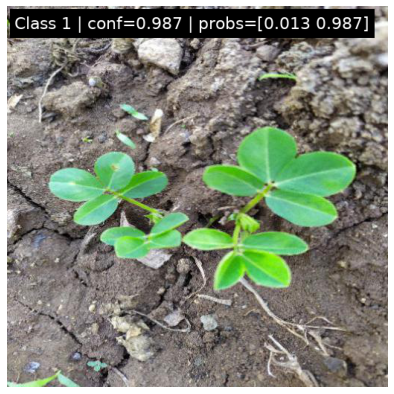

In [39]:
pred_id, probs = predict_and_show_full("/kaggle/input/crop-and-weed-detection-data-with-bounding-boxes/agri_data/data/agri_0_1173.jpeg")

In [34]:
def predict_and_show_crop(img_path, xmin, ymin, xmax, ymax, show_bbox=True):
    img = Image.open(img_path).convert("RGB")

    # clip bbox to image bounds
    W, H = img.size
    xmin = max(0, min(int(xmin), W-1))
    ymin = max(0, min(int(ymin), H-1))
    xmax = max(xmin+1, min(int(xmax), W))
    ymax = max(ymin+1, min(int(ymax), H))

    crop = img.crop((xmin, ymin, xmax, ymax))

    pred_id, probs = predict_pil(crop)
    conf = float(probs[pred_id])
    text = f"{id2name[pred_id]} | conf={conf:.3f} | probs={np.round(probs, 3)}"

    # show original image with bbox + label
    if show_bbox:
        img_box = draw_bbox(img, xmin, ymin, xmax, ymax)
        img_box = draw_label_on_image(img_box, text, xy=(10,10))
        plt.figure(figsize=(7,7))
        plt.imshow(img_box)
        plt.axis("off")
        plt.show()

    # show the crop too (what the model actually saw)
    crop_vis = draw_label_on_image(crop.resize((224,224)), text, xy=(10,10))
    plt.figure(figsize=(5,5))
    plt.imshow(crop_vis)
    plt.axis("off")
    plt.title("Cropped region (model input)")
    plt.show()

    return pred_id, probs

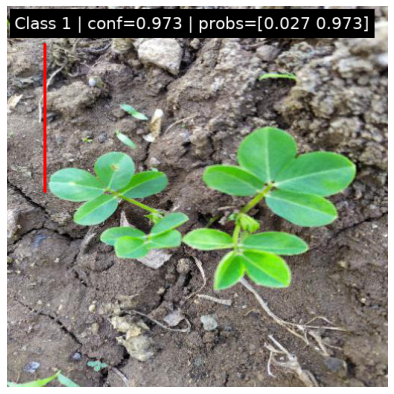

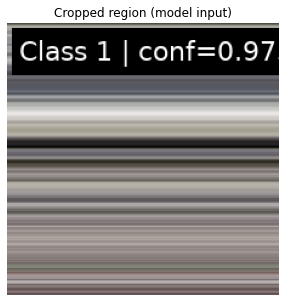

In [40]:
pred_id, probs = predict_and_show_crop(
    "/kaggle/input/crop-and-weed-detection-data-with-bounding-boxes/agri_data/data/agri_0_1173.jpeg",
    xmin=50, ymin=50, xmax=250, ymax=250
)